**分布強化学習(分位点を用いた)**
---

---

今回は分位点を用いた分布強化学習を説明し、それを動的計画法で解いていきたいと思います。

まずはじめに分布強化学習の簡単な説明をしていくと、強化学習は累積報酬和の期待値の最大化$V^\pi(x)=\mathbb{E}_x^\pi\left[\sum_{t=0}^{\infty} \gamma^t R_t\right]$を目的にして学習を進めていきます。

しかし、期待値を取ることで、他の大事な分布に備わっていたものが、欠如してしますのではないかという懸念から分布強化学習が作られました。

つまり、期待値を取らずに分布ごと学習していくという流れになります。

$$
\eta^\pi(x)=\mathcal{D}_x^\pi\left(\sum_{t \geq 0} \gamma^t R_t\right)
$$

---

そして今回は分布の更新ではなく、累積分布の逆関数(分位点)を使い学習していきます。

分布を更新する際は理想的な価値分布の事前設定や、作用素の工夫、報酬がunboundedの場合、難しくなってしまう懸念があり、分位点などの他のstatistical functionalで評価していくのが流行りになりつつあります。

分位点で更新したあとの価値分布の近似は次のようになります。

$$
\eta(x)=\sum_{i=1}^m \frac{1}{m} \delta_{\theta(x, i)}
$$

直感的に説明すると、我々が今求めたいのは、$[0,1]$の任意の分位の入力からそのときの価値を知りたいということです。

今、$\theta_i$には1番目の分位の価値が入っています。

アルゴリズムの実装例を下に図示します。

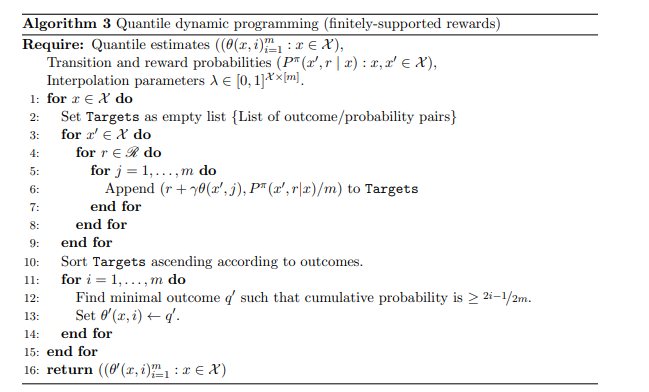

---

In [20]:
import numpy as np
from typing import NamedTuple,Optional
import matplotlib.pyplot as plt
np.random.seed(123)
S = 4 #state_size
A = 2  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99

rew = np.random.rand(S,A) #報酬

P = np.random.rand(S,A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array
    horizon : int

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

horizon = int(1 / (1 - gamma))
mdp = MDP(S_array,A_array,gamma,rew,P,horizon)
print(mdp.rew.shape)
print(mdp.P.shape)
print(mdp.S)

(4, 2)
(4, 2, 4)
4


In [21]:
import numpy as np

def quantile_dynamic_programming(theta:np.ndarray, mdp:MDP, gamma:float) -> np.array:
    """
    Quantile Dynamic Programming

    Parameters
    ----------
    theta : np.array
        quantile function
    mdp : MDP
        MDP
    gamma : float
        discount factor

    Returns
    -------
    theta_prime : np.array
        next quantile function

    """
    m = theta.shape[1]

    theta_prime = np.zeros_like(theta)

    for x in range(mdp.S):
        targets = {'outcome': [], 'probability': []}
        for x_prime in range(mdp.S):
            for j in range(m):
                action_index = np.argmax(mdp.rew[x])
                new_theta = mdp.rew[x, action_index] + gamma * theta[x_prime, j]
                probability = mdp.P[x, action_index, x_prime]
                targets['outcome'].append(new_theta)
                targets['probability'].append(probability)

        #分位点を中心に考えてるので、ソートして累積分布を求められる
        sorted_indices = np.argsort(targets['outcome'])
        outcomes = np.array(targets['outcome'])[sorted_indices]
        probabilities = np.array(targets['probability'])[sorted_indices]

        cumulative_probability = 0
        for i in range(1, m + 1):
            target_index = 0
            while cumulative_probability < (2 * i - 1) / 2 :
                #i番目の分位を遷移確率が超えるまで足し、その中で超えない最大のindex分位として採用
                cumulative_probability += probabilities[target_index]
                target_index += 1

            q_prime = outcomes[target_index - 1]
            theta_prime[x, i - 1] = q_prime

    return theta_prime



In [22]:
def V_Iteration(mdp: MDP):
    S,A = mdp.S,mdp.A
    Q = np.zeros((S,A))
    for s in range(S):
        for a in range(A):
            for s_dash in range(S):
                Q[s,a] = mdp.rew[s,a] + mdp.gamma * mdp.P[s,a,s_dash] * np.max(Q[s_dash,:])
    V = np.max(Q,axis=-1)
    return V

In [23]:
m = 2
theta = np.zeros((mdp.S, m))

re = quantile_dynamic_programming(theta, mdp, gamma)
V_tau = re.sum(axis=-1)/m
V = V_Iteration(mdp)
np.max(np.abs(V-V_tau))

0.21627472546789572

In [24]:
m = 10000
theta = np.zeros((mdp.S, m))

re = quantile_dynamic_programming(theta, mdp, gamma)
V_tau = re.sum(axis=-1)/m
V = V_Iteration(mdp)
np.max(np.abs(V-V_tau))

0.2162747254678955